<a target="_blank" href="https://colab.research.google.com/github/Aaronau667/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_ElegantRL.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [2]:
## install finrl library
!pip install wrds
!pip install swig
!pip install ccxt==1.66.1
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pyportfolioopt
!pip install pandas-market-calendars
!pip install zipline-reloaded
## instal elegantrl
!pip install git+https://github.com/AI4Finance-Foundation/elegantrl.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.6/168.6 kB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of aiohttp to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiohttp to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━


<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.elegantrl.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

from elegantrl.agents import AgentDDPG
from elegantrl.agents import AgentPPO
from elegantrl.agents import AgentTD3
from elegantrl.agents import AgentSAC

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [5]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [6]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'


In [7]:
import os
import pandas as pd
from datetime import datetime
import time
import random
import requests

def download_and_save_data(start_date, end_date, ticker_list, data_dir='./data'):

    # Create data storage directory
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Generate filename (using date range)
    file_name = f"dow30_data_{start_date}_{end_date}.csv"
    file_path = os.path.join(data_dir, file_name)

    # Check if file already exists
    if os.path.exists(file_path):
        print(f"Loading existing data from {file_path}")
        return pd.read_csv(file_path, index_col=0, parse_dates=True)

    print("Downloading data from Yahoo Finance...")
    # Use modified download function
    def download_with_retry(ticker, start_date, end_date, max_retries=3, delay=2):
        for attempt in range(max_retries):
            try:
                data = YahooDownloader(start_date=start_date,
                                     end_date=end_date,
                                     ticker_list=[ticker]).fetch_data()
                return data
            except Exception as e:
                if attempt < max_retries - 1:
                    sleep_time = delay + random.uniform(0, 1)
                    print(f"Download failed for {ticker}, retrying in {sleep_time:.2f} seconds...")
                    time.sleep(sleep_time)
                else:
                    print(f"Failed to download {ticker} after {max_retries} attempts")
                    raise e

    # Download all stock data
    all_data = []
    for ticker in ticker_list:
        try:
            data = download_with_retry(ticker, start_date, end_date)
            all_data.append(data)
            print(f"Successfully downloaded {ticker}")
        except Exception as e:
            print(f"Error downloading {ticker}: {str(e)}")

    # Merge all data
    if all_data:
        final_df = pd.concat(all_data, axis=0)
        # Save to CSV file
        final_df.to_csv(file_path)
        print(f"Data saved to {file_path}")
        return final_df
    else:
        raise Exception("No data was downloaded successfully")

# Use modified function
df = download_and_save_data(
    start_date=TRAIN_START_DATE,
    end_date=TRADE_END_DATE,
    ticker_list=config_tickers.DOW_30_TICKER
)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded AXP


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded AMGN


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded AAPL


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded BA


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded CAT


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded CSCO


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded CVX


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded GS


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded HD


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded HON


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded IBM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded INTC


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded JNJ


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded KO


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded JPM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded MCD


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded MMM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded MRK


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded MSFT


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded NKE


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded PG


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded TRV


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded UNH


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded CRM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded VZ


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded V


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded WBA


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3230, 8)
Successfully downloaded WMT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3230, 8)
Successfully downloaded DIS


Shape of DataFrame:  (661, 8)
Successfully downloaded DOW
Data saved to ./data/dow30_data_2009-01-01_2021-10-31.csv


In [8]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [9]:
df.shape

(94331, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2009-01-02,2.727417,2.736134,2.559415,2.581054,746015200,AAPL,4
1,2009-01-02,40.791454,40.853689,39.933996,40.514854,6547900,AMGN,4
2,2009-01-02,14.929292,15.076036,14.211017,14.342315,10955700,AXP,4
3,2009-01-02,33.941097,34.173623,32.088400,32.103402,7010200,BA,4
4,2009-01-02,30.344688,30.389969,28.921573,29.050948,7117200,CAT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [11]:
import os

# Create data directory if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")


processed_file_path = f"data/dow30_data_{TRAIN_START_DATE}_{TRADE_END_DATE}_processed.csv"

# Check if processed data already exists
if os.path.exists(processed_file_path):
    print(f"Loading existing processed data from {processed_file_path}")
    processed = pd.read_csv(processed_file_path)
else:
    print("Processing data...")
    fe = FeatureEngineer(
                        use_technical_indicator=True,
                        tech_indicator_list = INDICATORS,
                        use_vix=True,
                        use_turbulence=True,
                        user_defined_feature = False)

    processed = fe.preprocess_data(df)

    # Save processed data to data directory
    processed.to_csv(processed_file_path, index=False)
    print(f"Processed data saved to {processed_file_path}")

Processing data...
Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index
Processed data saved to data/dow30_data_2009-01-01_2021-10-31_processed.csv


In [12]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [13]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,2.727417,2.736134,2.559415,2.581054,746015200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,2.727417,2.727417,39.189999,0.0
1,2009-01-02,AMGN,40.791454,40.853689,39.933996,40.514854,6547900.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,40.791454,40.791454,39.189999,0.0
2,2009-01-02,AXP,14.929292,15.076036,14.211017,14.342315,10955700.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,14.929292,14.929292,39.189999,0.0
3,2009-01-02,BA,33.941097,34.173623,32.088400,32.103402,7010200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,33.941097,33.941097,39.189999,0.0
4,2009-01-02,CAT,30.344688,30.389969,28.921573,29.050948,7117200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,30.344688,30.344688,39.189999,0.0
5,2009-01-02,CRM,8.444491,8.489171,7.856207,7.967906,4069200.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,8.444491,8.444491,39.189999,0.0
6,2009-01-02,CSCO,11.166079,11.192414,10.698631,10.803972,40980600.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,11.166079,11.166079,39.189999,0.0
7,2009-01-02,CVX,39.716717,40.121569,38.190750,38.528125,13695900.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,39.716717,39.716717,39.189999,0.0
8,2009-01-02,DIS,20.346149,20.439715,19.138309,19.359463,9796600.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,20.346149,20.346149,39.189999,0.0
9,2009-01-02,GS,65.680321,66.331371,62.220673,63.606042,14088500.0,4.0,0.0,2.947758,2.622184,100.0,66.666667,100.0,65.680321,65.680321,39.189999,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [14]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))



83897
9744


In [15]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,275.247772,276.647574,268.444726,269.293943,2932900.0,1.0,-0.018627,290.693727,259.441649,52.413059,-20.025828,0.598739,275.480992,268.767352,30.43,12.918683
2892,2020-06-30,V,186.425125,186.984875,183.520230,184.803792,9040100.0,1.0,1.025077,194.257213,180.858028,53.021050,-51.427370,2.103941,187.155986,177.570355,30.43,12.918683
2892,2020-06-30,VZ,41.323425,41.443355,40.746261,41.166015,17414800.0,1.0,-0.358557,44.228630,39.972072,48.097022,-50.671580,8.321506,41.844624,42.215851,30.43,12.918683
2892,2020-06-30,WBA,32.880192,33.027569,32.391526,32.670763,4782100.0,1.0,-0.070743,35.890251,30.733453,48.830175,-14.267063,0.948751,32.963969,32.795457,30.43,12.918683
2892,2020-06-30,WMT,37.177689,37.286321,36.792813,37.003876,20509200.0,1.0,-0.283845,38.250866,36.341645,48.159674,-69.838543,3.557765,37.711031,38.330751,30.43,12.918683


In [16]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,88.485023,89.274830,88.436424,88.730473,110737200.0,2.0,2.967003,91.235602,78.913905,62.807137,107.472499,29.811415,82.608454,76.490385,28.620001,53.068429
0,2020-07-01,AMGN,218.336411,219.286383,199.046267,201.562376,6575800.0,2.0,3.306030,211.284530,182.023973,61.279638,272.795320,47.009997,195.339144,196.314669,28.620001,53.068429
0,2020-07-01,AXP,88.493980,91.232068,88.108198,89.623087,3301000.0,2.0,-0.373982,106.116181,84.335740,48.504813,-62.638393,1.752114,93.451014,87.157391,28.620001,53.068429
0,2020-07-01,BA,180.320007,190.610001,180.039993,185.880005,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.936440,176.472335,155.614168,28.620001,53.068429
0,2020-07-01,CAT,113.824570,116.840385,113.662040,116.822336,2807800.0,2.0,1.200618,123.232910,106.939031,52.865423,35.366503,14.542315,112.655858,107.215974,28.620001,53.068429


In [18]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [19]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension




## Environment for Training



In [20]:
from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
e_train_gym = StockTradingEnv

<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [22]:

# Pivot close prices to get a 2D array: rows are dates, columns are tickers
price_array = train.pivot(index="date", columns="tic", values="close").values

# Pivot technical indicators: stack all indicators for all stocks
tech_list = []
for indicator in INDICATORS:
    tech_list.append(train.pivot(index="date", columns="tic", values=indicator).values)
# Stack along the last axis and flatten stocks and indicators
# The reshape here assumes that for each date, all tech indicators for all stocks are concatenated
tech_array = np.stack(tech_list, axis=2)  # shape: (dates, stocks, indicators)
tech_array = tech_array.reshape(tech_array.shape[0], -1)  # shape: (dates, stocks * indicators)


# Pivot turbulence: one value per date
# Use .values to get a numpy array from the pandas Series
turbulence_array = train.groupby("date")["turbulence"].first().values
print("Price array shape:", price_array.shape)
print("Tech array shape:", tech_array.shape)
print("Turbulence array shape:", turbulence_array.shape)

print("\nFirst few rows of price array:")
print(price_array[:5])

print("\nFirst few rows of tech array:")
print(tech_array[:5])

print("\nFirst few values of turbulence array:")
print(turbulence_array[:5])




Price array shape: (2893, 29)
Tech array shape: (2893, 232)
Turbulence array shape: (2893,)

First few rows of price array:
[[ 2.72741699 40.79145432 14.92929173 33.94109726 30.34468842  8.44449139
  11.16607857 39.71671677 20.34614944 65.68032074 16.14861679 22.74679565
  47.71530151  9.51694965 37.49147415 20.97311401 13.85559177 40.46822739
  29.90019608 16.849123   14.89742851 10.76207638 38.79340363 30.62789536
  21.92787933 11.87676334 13.9325428  15.30581856 13.43323135]
 [ 2.84252501 41.24783325 15.408144   34.63117599 29.80778885  8.27818203
  11.26483631 39.78939056 19.98889923 67.20957184 16.53677559 22.62866974
  47.41493988  9.33537483 37.12057877 19.56822205 13.71673107 40.34762573
  29.5516243  16.59367371 15.03665638 10.83914661 38.51542282 30.17388344
  21.57022285 11.96121502 13.06377125 16.07859612 13.27818298]
 [ 2.79564023 40.3419838  16.27316284 34.73617935 29.62665749  8.58845997
  11.71253109 40.14753342 20.6778717  67.15657806 16.90485382 23.65247726
  48.73109

In [34]:
# Import required classes from FinRL and ElegantRL
# Note: Import path may need to be adjusted based on your FinRL installation
from finrl.agents.elegantrl.models import DRLAgent

# Environment setup using FinRL's approach
# Dictionary containing data arrays and environment configuration parameters
env_kwargs_with_data = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "price_array": price_array,
    "tech_array": tech_array,
    "turbulence_array": turbulence_array,
    "if_train": True,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "action_space": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "reward_scaling": 1e-4,
}

# Create agent instance
agent = DRLAgent(
    env=e_train_gym,
    price_array=price_array,
    tech_array=tech_array,
    turbulence_array=turbulence_array
)

# Define ElegantRL DDPG algorithm hyperparameters
erl_params = {
    "learning_rate": 3e-5,
    "gamma": 0.99,
    "tau": 0.01,
    "buffer_size": 50000,
    "net_dims": [512, 512],
    "batch_size": 10240,
    "target_step": 5000,
    "eval_gap": 60,
    "eval_times": 1,
    "gpu_id": 0,
}


In [33]:

if_using_a2c = False
if_using_ddpg = True
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


In [32]:
import os

cpu_count = os.cpu_count()
print(f"Colab 分配的 CPU 线程数: {cpu_count}")

!nvidia-smi

Colab 分配的 CPU 线程数: 2
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
stop

### Agent 1: A2C


### Agent 2: DDPG

In [29]:

# Get ElegantRL DDPG model instance
# Call get_model method of DRLAgent_erl instance with algorithm name ("ddpg") and ElegantRL hyperparameters (erl_params)
model_name = "ddpg" # Specify the ElegantRL algorithm to train
model = agent.get_model(model_name, model_kwargs = erl_params)

# Define training results save directory
# cwd will be created relative to your current working directory
cwd = RESULTS_DIR + '/' + model_name + '_finrl_integration' # Save to a new folder under RESULTS_DIR

# Set total training steps
total_timesteps = 100000 # Adjust total training steps as needed

# --- Start Training ---
import time
print(f"=== Starting {model_name.upper()} Training ===")
start_time = time.time()

# Call train_model method of DRLAgent instance to start training
# This method will handle the ElegantRL internal training loop
trained_model = agent.train_model(
    model = model, # Pass the ElegantRL model instance obtained above
    cwd = cwd, # Pass the save directory
    total_timesteps = total_timesteps # Pass the total steps parameter
)

print(f"=== {model_name.upper()} Training Complete ===")
print(f"Total time: {time.time() - start_time:.2f} seconds")

=== Starting DDPG Training ===
| train_agent_multiprocessing() with GPU_ID 0
| Arguments Remove cwd: results/ddpg_finrl_integration


KeyboardInterrupt: 

### Agent 3: PPO

### Agent 4: TD3

### Agent 5: SAC

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [35]:
insample_risk_indicator.vix.describe()

NameError: name 'insample_risk_indicator' is not defined

In [31]:
insample_risk_indicator.vix.quantile(0.996)

NameError: name 'insample_risk_indicator' is not defined

In [36]:
insample_risk_indicator.turbulence.describe()

NameError: name 'insample_risk_indicator' is not defined

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

np.float64(276.45263915168357)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
#e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [37]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,88.485023,89.274830,88.436424,88.730473,110737200.0,2.0,2.967003,91.235602,78.913905,62.807137,107.472499,29.811415,82.608454,76.490385,28.620001,53.068429
0,2020-07-01,AMGN,218.336411,219.286383,199.046267,201.562376,6575800.0,2.0,3.306030,211.284530,182.023973,61.279638,272.795320,47.009997,195.339144,196.314669,28.620001,53.068429
0,2020-07-01,AXP,88.493980,91.232068,88.108198,89.623087,3301000.0,2.0,-0.373982,106.116181,84.335740,48.504813,-62.638393,1.752114,93.451014,87.157391,28.620001,53.068429
0,2020-07-01,BA,180.320007,190.610001,180.039993,185.880005,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.936440,176.472335,155.614168,28.620001,53.068429
0,2020-07-01,CAT,113.824570,116.840385,113.662040,116.822336,2807800.0,2.0,1.200618,123.232910,106.939031,52.865423,35.366503,14.542315,112.655858,107.215974,28.620001,53.068429


In [38]:

# Pivot close prices to get a 2D array: rows are dates, columns are tickers
price_array = trade.pivot(index="date", columns="tic", values="close").values

# Pivot technical indicators: stack all indicators for all stocks
tech_list = []
for indicator in INDICATORS:
    tech_list.append(trade.pivot(index="date", columns="tic", values=indicator).values)
# Stack along the last axis and flatten stocks and indicators
# The reshape here assumes that for each date, all tech indicators for all stocks are concatenated
tech_array = np.stack(tech_list, axis=2)  # shape: (dates, stocks, indicators)
tech_array = tech_array.reshape(tech_array.shape[0], -1)  # shape: (dates, stocks * indicators)


# Pivot turbulence: one value per date
# Use .values to get a numpy array from the pandas Series
turbulence_array = trade.groupby("date")["turbulence"].first().values
print("Price array shape:", price_array.shape)
print("Tech array shape:", tech_array.shape)
print("Turbulence array shape:", turbulence_array.shape)

print("\nFirst few rows of price array:")
print(price_array[:5])

print("\nFirst few rows of tech array:")
print(tech_array[:5])

print("\nFirst few values of turbulence array:")
print(turbulence_array[:5])


e_trade_gym = StockTradingEnv

Price array shape: (336, 29)
Tech array shape: (336, 232)
Turbulence array shape: (336,)

First few rows of price array:
[[ 88.4850235  218.33641052  88.49398041 180.32000732 113.8245697
  190.52481079  39.54502487  70.36941528 111.63095856 176.1073761
  221.37138367 130.24783325  90.75139618  52.42577744 122.84657288
   81.15140533  38.78709412 165.65065002 107.1450882   64.44498444
  196.12016296  91.97579956 106.07866669 101.5762558  277.8420105
  187.0138092   40.97862625  31.70894623  37.14976883]
 [ 88.4850235  221.00654602  88.75743866 180.80999756 115.32345581
  191.16023254  39.48444748  70.92355347 110.8110733  175.95584106
  221.68367004 131.07032776  91.63948822  52.71103287 123.36286926
   81.41499329  38.83902359 164.62805176 108.25493622  64.98946381
  197.61477661  92.94841766 106.87436676 101.54016113 278.33660889
  188.83779907  41.06857681  32.56217575  37.00077057]
 [ 90.85202026 219.30345154  90.87451935 187.91000366 116.86746216
  196.31332397  40.16804504  71.132

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [43]:
import torch
from finrl.agents.elegantrl.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv

# Build environment configuration
config = {
    "price_array": price_array,
    "tech_array": tech_array,
    "turbulence_array": turbulence_array,
    "if_train": False  # Test mode
}

# Ensure costs are scalar values, not lists
buy_cost = 0.001  # Use a unified transaction cost value
sell_cost = 0.001  # Use a unified transaction cost value

# Create environment instance
e_trade_gym = StockTradingEnv(
    config=config,
    initial_account=1000000,
    max_stock=100,
    buy_cost_pct=buy_cost_list,
    sell_cost_pct=sell_cost_list,
    reward_scaling=1e-4
)

# Create DRLAgent instance
agent = DRLAgent(
    env=e_trade_gym,
    price_array=price_array,
    tech_array=tech_array,
    turbulence_array=turbulence_array
)

# Prediction
cwd = RESULTS_DIR + '/ddpg_finrl_integration'

# Build correct env_args
stock_dim = price_array.shape[1]
state_dim = 1 + 2 + 3 * stock_dim + tech_array.shape[1]
action_dim = stock_dim

env_args = {
    "env_num": 1,
    "env_name": "StockEnv",
    "state_dim": state_dim,
    "action_dim": action_dim,
    "if_discrete": False,
    "max_step": price_array.shape[0] - 1,
    "price_array": price_array,  # Place directly at top level
    "tech_array": tech_array,    # Place directly at top level
    "turbulence_array": turbulence_array,  # Place directly at top level
    "if_train": False
}

# Handle reset() method returning tuple
reset_result = e_trade_gym.reset()
if isinstance(reset_result, tuple):
    initial_state = reset_result[0]  # Get observation part
else:
    initial_state = reset_result

# Modify environment's reset method to ensure it only returns state not tuple
original_reset = e_trade_gym.reset

def new_reset(*args, **kwargs):
    result = original_reset(*args, **kwargs)
    if isinstance(result, tuple):
        return result[0]  # Only return observation, not info
    return result

e_trade_gym.reset = new_reset

# Patch step method to handle list-type transaction costs and return value format mismatch
original_step = e_trade_gym.step

def new_step(actions):
    try:
        result = original_step(actions)
        # Check if return value has 5 elements (new Gym version)
        if isinstance(result, tuple) and len(result) == 5:
            state, reward, terminated, truncated, info = result
            # Combine terminated and truncated into one done variable
            done = terminated or truncated
            # Return old format
            return state, reward, done, info
        return result
    except TypeError as e:
        if "unsupported operand type(s) for -: 'int' and 'list'" in str(e):
            # Fix sell_cost_pct type issue
            if isinstance(e_trade_gym.sell_cost_pct, list):
                e_trade_gym.sell_cost_pct = e_trade_gym.sell_cost_pct[0] if e_trade_gym.sell_cost_pct else 0.001
            if isinstance(e_trade_gym.buy_cost_pct, list):
                e_trade_gym.buy_cost_pct = e_trade_gym.buy_cost_pct[0] if e_trade_gym.buy_cost_pct else 0.001
            # Retry and handle return value
            result = original_step(actions)
            if isinstance(result, tuple) and len(result) == 5:
                state, reward, terminated, truncated, info = result
                done = terminated or truncated
                return state, reward, done, info
            return result
        else:
            raise

e_trade_gym.step = new_step

import torch
import importlib


original_torch_load = torch.load


def new_torch_load(f, map_location=None, pickle_module=None, **kwargs):

    return original_torch_load(
        f,
        map_location=torch.device('cpu'),
        pickle_module=pickle_module,
        weights_only=False,
        **kwargs
    )


torch.load = new_torch_load

episode_total_assets = agent.DRL_prediction(
    model_name="ddpg",
    cwd=cwd,
    net_dimension=[512, 512],
    environment=e_trade_gym,
    env_args=env_args
)


Test Finished!
episode_retuen 1.330063613931958


<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed

Total asset sequence length: 335
Using business days from 2019-01-02 to 2020-04-14
Retrieved 335 days of Dow Jones data
First few trading days in Dow data:
Ticker          ^DJI
Date                
2018-12-26  0.049846
2018-12-27  0.011381
2018-12-28 -0.003303
2018-12-31  0.011493
2019-01-02  0.000805


Successfully mapped 334 strategy days to trading days
Successfully created benchmark comparison with 334 days

===== Trading Statistics =====
Initial Asset: 1000000.00
Final Asset: 1330063.61
Trading Days: 334
Profitable Days: 177 (53.0%)
Loss Days: 156 (46.7%)

===== Return Statistics =====
Total Return: 33.01%
Annualized Return: 24.01%
Maximum Drawdown: -10.65%
Sharpe Ratio: 1.53

===== Benchmark Comparison (Dow Jones) =====
Strategy Total Return: 33.01% | Benchmark: 9.26%
Strategy Annual Return: 24.01% | Benchmark: 6.91%
Strategy Sharpe Ratio: 1.53 | Benchmark: 0.37
Alpha: 17.10%


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)



Trading Results:


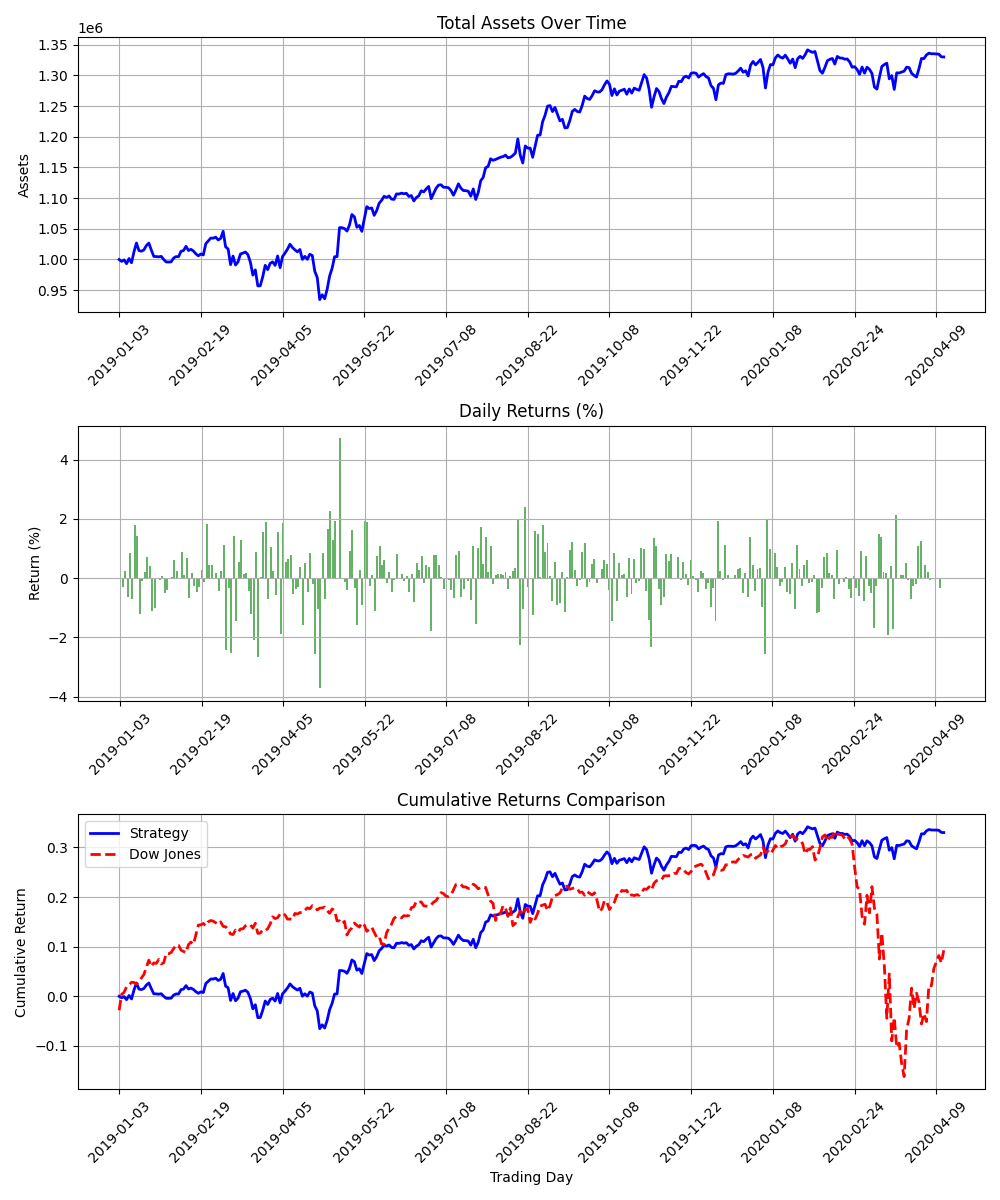

In [53]:
# Simple backtest results printing with Dow Jones Industrial Average comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from IPython.display import Image, display
import yfinance as yf  # For market data
import traceback

# Ensure output directory exists
output_dir = './output_charts'
os.makedirs(output_dir, exist_ok=True)

# Print total asset sequence length
print("Total asset sequence length:", len(episode_total_assets))

# Generate business days (skipping weekends)
def generate_business_days(start_date, num_days):
    business_days = []
    current_date = start_date
    while len(business_days) < num_days:
        # Check if it's a business day (Monday to Friday)
        if current_date.weekday() < 5:  # 0-4 represents Monday to Friday
            business_days.append(current_date)
        current_date += timedelta(days=1)
    return business_days

# Use dates from 2019 (to ensure past dates)
start_date = datetime(2019, 1, 2)  # Start from Jan 2, 2019 (likely a trading day)
dates = generate_business_days(start_date, len(episode_total_assets))
end_date = dates[-1]

print(f"Using business days from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'total_assets': episode_total_assets
})

# Calculate daily returns
df['daily_return'] = df['total_assets'].pct_change()

# Skip first NaN value
df = df.iloc[1:]

# Get Dow Jones Industrial Average data
try:
    # Use a wider date range to ensure enough trading days
    start_str = (start_date - timedelta(days=10)).strftime('%Y-%m-%d')
    end_str = (end_date + timedelta(days=10)).strftime('%Y-%m-%d')

    print(f"Downloading Dow Jones data from {start_str} to {end_str}")
    dow_data = yf.download('^DJI', start=start_str, end=end_str)

    print(f"Retrieved {len(dow_data)} days of Dow Jones data")

    # Check if data was retrieved
    if not dow_data.empty and len(dow_data) > 5:
        # Yahoo Finance returns trading day data
        dow_daily = dow_data['Close']

        # Calculate daily returns
        dow_returns = dow_daily.pct_change().dropna()

        # Print first few trading days for diagnostics
        print("First few trading days in Dow data:")
        print(dow_returns.head())

        # Create mapping between strategy dates and benchmark dates
        date_map = {}
        for strategy_date in df['date']:
            # Find closest trading day not exceeding strategy date
            trading_days = dow_returns.index[dow_returns.index <= strategy_date]
            if len(trading_days) > 0:
                date_map[strategy_date] = trading_days[-1]

        if date_map:
            print(f"Successfully mapped {len(date_map)} strategy days to trading days")

            # Create benchmark returns series
            benchmark_returns = []
            valid_strategy_dates = []

            for strategy_date in df['date']:
                if strategy_date in date_map:
                    trading_date = date_map[strategy_date]
                    benchmark_returns.append(dow_returns.loc[trading_date])
                    valid_strategy_dates.append(strategy_date)

            # Create benchmark and strategy cumulative returns
            benchmark_returns_series = pd.Series(benchmark_returns)
            benchmark_cumulative = (1 + benchmark_returns_series).cumprod()
            strategy_returns = df.loc[df['date'].isin(valid_strategy_dates), 'daily_return'].values
            strategy_cumulative = (1 + pd.Series(strategy_returns)).cumprod()

            has_benchmark = True
            print(f"Successfully created benchmark comparison with {len(benchmark_returns)} days")
        else:
            has_benchmark = False
            print("Could not map any strategy days to trading days")
    else:
        has_benchmark = False
        print(f"Insufficient Dow Jones data retrieved: {len(dow_data)} days")
except Exception as e:
    has_benchmark = False
    print(f"Failed to retrieve Dow Jones data: {str(e)}")
    traceback.print_exc()  # Print detailed error information
    print("Showing strategy results only")

# Basic statistics
total_days = len(df)
positive_days = sum(df['daily_return'] > 0)
negative_days = sum(df['daily_return'] < 0)

# Calculate cumulative return
initial_value = episode_total_assets[0]
final_value = episode_total_assets[-1]
total_return = (final_value / initial_value - 1) * 100

# Calculate annualized return (assuming 252 trading days)
annual_return = ((final_value / initial_value) ** (252 / total_days) - 1) * 100

# Calculate maximum drawdown
running_max = np.maximum.accumulate(episode_total_assets)
drawdown = (np.array(episode_total_assets) / running_max - 1) * 100
max_drawdown = np.min(drawdown)

# Calculate Sharpe ratio (assuming risk-free rate of 0)
daily_returns = df['daily_return'].values
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)

# Print statistics
print("\n===== Trading Statistics =====")
print(f"Initial Asset: {initial_value:.2f}")
print(f"Final Asset: {final_value:.2f}")
print(f"Trading Days: {total_days}")
print(f"Profitable Days: {positive_days} ({positive_days/total_days*100:.1f}%)")
print(f"Loss Days: {negative_days} ({negative_days/total_days*100:.1f}%)")
print("\n===== Return Statistics =====")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annual_return:.2f}%")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

if has_benchmark:
    # Calculate benchmark statistics - Fix formatting errors
    # Use .iloc[0] instead of float() conversion
    benchmark_total_return_value = (benchmark_cumulative.iloc[-1] - 1) * 100
    if isinstance(benchmark_total_return_value, pd.Series):
        benchmark_total_return_value = benchmark_total_return_value.iloc[0]

    benchmark_annual_return_value = ((benchmark_cumulative.iloc[-1]) ** (252 / len(benchmark_cumulative)) - 1) * 100
    if isinstance(benchmark_annual_return_value, pd.Series):
        benchmark_annual_return_value = benchmark_annual_return_value.iloc[0]

    # Extract pure numerical array for Sharpe ratio calculation
    benchmark_returns_values = []
    for x in benchmark_returns_series.values:
        if isinstance(x, pd.Series):
            benchmark_returns_values.append(x.iloc[0])
        else:
            benchmark_returns_values.append(x)

    benchmark_returns_values = np.array(benchmark_returns_values)
    benchmark_sharpe_value = np.mean(benchmark_returns_values) / np.std(benchmark_returns_values) * np.sqrt(252)

    print("\n===== Benchmark Comparison (Dow Jones) =====")
    print(f"Strategy Total Return: {total_return:.2f}% | Benchmark: {benchmark_total_return_value:.2f}%")
    print(f"Strategy Annual Return: {annual_return:.2f}% | Benchmark: {benchmark_annual_return_value:.2f}%")
    print(f"Strategy Sharpe Ratio: {sharpe_ratio:.2f} | Benchmark: {benchmark_sharpe_value:.2f}")
    print(f"Alpha: {annual_return - benchmark_annual_return_value:.2f}%")

# Create explicit numeric indices for plotting
x_indices = np.arange(len(df))

# Asset change curve plot
plt.figure(figsize=(10, 6))
plt.plot(x_indices, df['total_assets'].values, 'b-', linewidth=2, label='Strategy Assets')
plt.title('Total Assets Over Time')
plt.ylabel('Assets')
plt.grid(True)
plt.legend()

# Set date labels for X-axis, showing only some to avoid crowding
step = max(1, len(x_indices) // 10)
selected_indices = x_indices[::step]
selected_dates = [dates[i+1].strftime('%Y-%m-%d') for i in selected_indices if i+1 < len(dates)]
plt.xticks(selected_indices[:len(selected_dates)], selected_dates, rotation=45)
plt.tight_layout()

# Save chart
assets_chart_path = os.path.join(output_dir, 'assets_over_time.png')
plt.savefig(assets_chart_path, dpi=100)
plt.close()

# Daily returns plot
plt.figure(figsize=(10, 6))
plt.bar(x_indices, df['daily_return'].values * 100, color='g', alpha=0.6, label='Strategy Returns')
plt.title('Daily Returns (%)')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.xticks(selected_indices[:len(selected_dates)], selected_dates, rotation=45)
plt.tight_layout()

# Save chart
returns_chart_path = os.path.join(output_dir, 'daily_returns.png')
plt.savefig(returns_chart_path, dpi=100)
plt.close()

# Cumulative returns comparison plot (if benchmark data available)
if has_benchmark:
    plt.figure(figsize=(10, 6))

    # Ensure index lengths match
    strategy_plot_indices = np.arange(len(strategy_cumulative))
    benchmark_plot_indices = np.arange(len(benchmark_cumulative))

    plt.plot(strategy_plot_indices, strategy_cumulative.values - 1, 'b-', linewidth=2, label='Strategy')
    plt.plot(benchmark_plot_indices, benchmark_cumulative.values - 1, 'r--', linewidth=2, label='Dow Jones')
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Trading Day')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()

    # Set appropriate ticks
    step = max(1, len(strategy_plot_indices) // 10)
    selected_indices = strategy_plot_indices[::step]
    if len(selected_dates) > len(selected_indices):
        selected_dates = selected_dates[:len(selected_indices)]
    plt.xticks(selected_indices[:len(selected_dates)], selected_dates, rotation=45)
    plt.tight_layout()

    # Save chart
    comparison_chart_path = os.path.join(output_dir, 'returns_comparison.png')
    plt.savefig(comparison_chart_path, dpi=100)
    plt.close()

# Combined chart
if has_benchmark:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
else:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Asset change curve plot
ax1.plot(x_indices, df['total_assets'].values, 'b-', linewidth=2)
ax1.set_title('Total Assets Over Time')
ax1.set_ylabel('Assets')
ax1.grid(True)
ax1.set_xticks(selected_indices[:len(selected_dates)])
ax1.set_xticklabels(selected_dates, rotation=45)

# Daily returns plot
ax2.bar(x_indices, df['daily_return'].values * 100, color='g', alpha=0.6)
ax2.set_title('Daily Returns (%)')
ax2.set_ylabel('Return (%)')
ax2.grid(True)
ax2.set_xticks(selected_indices[:len(selected_dates)])
ax2.set_xticklabels(selected_dates, rotation=45)

# Add cumulative returns comparison if benchmark data available
if has_benchmark:
    # Ensure index lengths match
    strategy_plot_indices = np.arange(len(strategy_cumulative))
    benchmark_plot_indices = np.arange(len(benchmark_cumulative))

    ax3.plot(strategy_plot_indices, strategy_cumulative.values - 1, 'b-', linewidth=2, label='Strategy')
    ax3.plot(benchmark_plot_indices, benchmark_cumulative.values - 1, 'r--', linewidth=2, label='Dow Jones')
    ax3.set_title('Cumulative Returns Comparison')
    ax3.set_xlabel('Trading Day')
    ax3.set_ylabel('Cumulative Return')
    ax3.grid(True)
    ax3.legend()

    # Set appropriate ticks
    step = max(1, len(strategy_plot_indices) // 10)
    selected_strategy_indices = strategy_plot_indices[::step]
    if len(selected_dates) > len(selected_strategy_indices):
        selected_dates_for_ax3 = selected_dates[:len(selected_strategy_indices)]
    else:
        selected_dates_for_ax3 = selected_dates
    ax3.set_xticks(selected_strategy_indices[:len(selected_dates_for_ax3)])
    ax3.set_xticklabels(selected_dates_for_ax3, rotation=45)
else:
    ax2.set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Save combined chart
combined_chart_path = os.path.join(output_dir, 'trading_results.png')
plt.savefig(combined_chart_path, dpi=100)
plt.close()

# Display only the combined chart to avoid duplication
print("\nTrading Results:")
display(Image(filename=combined_chart_path))